<a href="https://colab.research.google.com/github/iremaricii/data-pre-processing/blob/main/data_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [3]:
import pandas as pd
import re

df = pd.read_csv('dirty-dataset.csv', delimiter='|', dtype=str)

In [4]:
def akilli_temiz_ayir(name):
    if not isinstance(name, str) or name.strip() == '':
        return pd.Series(['Bilinmiyor', 'Bilinmiyor'])

    # Özel karakter -- boşluk
    cleaned = re.sub(r'[^A-Za-z]', ' ', name)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    # Boşluk varsa normal ayır
    if ' ' in cleaned:
        parts = cleaned.split(' ', 1)
        return pd.Series([parts[0], parts[1]])
    else:
        # Boşluk yok -- büyük harf ayır
        parts = re.findall(r'[A-Z][a-z]*', cleaned)
        if len(parts) >= 2:
            return pd.Series([parts[0], ' '.join(parts[1:])])
        elif len(parts) == 1:
            return pd.Series([parts[0], 'Bilinmiyor'])
        else:
            return pd.Series(['Bilinmiyor', 'Bilinmiyor'])

df[['name', 'surname']] = df['name'].apply(akilli_temiz_ayir)

In [ ]:
print(df[['id', 'name', 'surname']])

In [6]:
# Format maskeleme
mask_dd_mm_yyyy = df['date'].str.match(r'\d{2}/\d{2}/\d{4}', na=False)
mask_yyyy_mm_dd = df['date'].str.match(r'\d{4}/\d{2}/\d{2}', na=False)
mask_iso = df['date'].str.contains('-', na=False)

# Format bazlı dönüşüm
df.loc[mask_dd_mm_yyyy, 'date'] = pd.to_datetime(df.loc[mask_dd_mm_yyyy, 'date'], format='%d/%m/%Y', errors='coerce')
df.loc[mask_yyyy_mm_dd, 'date'] = pd.to_datetime(df.loc[mask_yyyy_mm_dd, 'date'], format='%Y/%m/%d', errors='coerce')
df.loc[mask_iso, 'date'] = pd.to_datetime(df.loc[mask_iso, 'date'], format='%Y-%m-%d', errors='coerce')

# Kalanlar için genel dönüşüm
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['date'] = df['date'].dt.date

In [ ]:
print(df[['date']])

In [8]:
# Boş string
df['city'] = df['city'].replace('', pd.NA)
df['city'] = df['city'].fillna('Bilinmiyor')

In [ ]:
print(df[['city']])

In [10]:
# Boşlukları sil-sayıya çevir-tam sayı yap
df['harcama'] = df['harcama'].astype(str).str.replace(' ', '')
df['harcama'] = pd.to_numeric(df['harcama'], errors='coerce')
df['harcama'] = df['harcama'].astype(int)


In [ ]:
print(df[['harcama']])

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df)

print("Boş name:", df['name'].eq('Bilinmiyor').sum())
print("Boş surname:", df['surname'].eq('Bilinmiyor').sum())
print("Eksik city:", df['city'].isnull().sum())
print("Eksik date:", df['date'].isnull().sum())
print("Eksik harcama:", df['harcama'].isnull().sum())

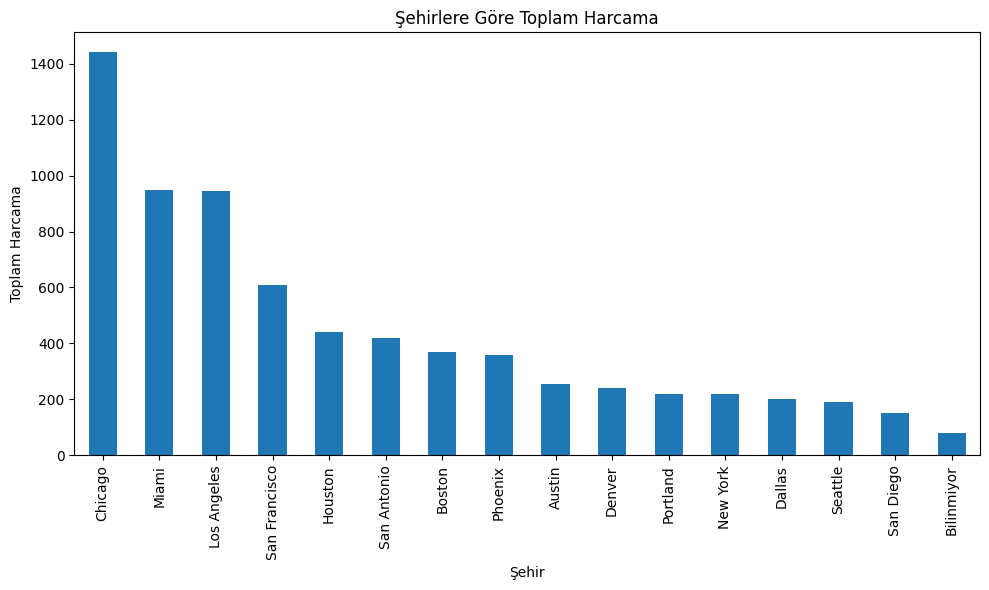

In [13]:
import matplotlib.pyplot as plt

# Şehirlere göre toplam harcama
city_harcama = df.groupby('city')['harcama'].sum().sort_values(ascending=False)

# Bar Grafik
plt.figure(figsize=(10,6))
city_harcama.plot(kind='bar')
plt.title('Şehirlere Göre Toplam Harcama')
plt.ylabel('Toplam Harcama')
plt.xlabel('Şehir')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['harcama_standardized'] = scaler.fit_transform(df[['harcama']])

print(df[['harcama', 'harcama_standardized']].head())


In [ ]:
from sklearn.linear_model import LinearRegression

# Özellikler ve hedef değişkeni ayırma
X = df[['harcama_standardized']]  # Özellikler
y = df['harcama']  # Hedef değişken

# Modeli başlat ve eğit
model = LinearRegression()
model.fit(X, y)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Test verisiyle tahmin
y_pred = model.predict(X)

# Metriklerin hesaplanması
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")


In [ ]:
from sklearn.model_selection import cross_val_score

# Modelin çapraz doğrulama ile test edilmesi
cv_scores = cross_val_score(model, X, y, cv=5)  # cv=5 5 katlı çapraz doğrulama
print(f"Çapraz Doğrulama Skorları: {cv_scores}")
print(f"Ortalama Çapraz Doğrulama Skoru: {cv_scores.mean()}")


In [18]:
df.to_csv('new_dataset.csv', sep=';', index=False)